In [1]:
import os 
import sys 
from pathlib import Path

current_dir = Path().resolve()
project_root = current_dir.parent.parent

# Verify we're in the right place (should contain data/, config/, etc.)
if not (project_root / "data").exists():
    raise RuntimeError(f"Project root not found at {project_root}. Expected to find 'data' directory.")

os.chdir(project_root)
sys.path.append(str(project_root))

print(f"✅ Project root set to: {project_root}")

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt 

from catboost import CatBoostRegressor, Pool
import optuna
from typing import Union, Dict, Tuple
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor as RF

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

✅ Project root set to: /Users/armindomatias/code/armindomatias/personal/ml-project


# Table of Contents
- Dataset Preparation
- Baseline Model 
- Baseline Model with target lag features
- Baseline Model with all lag features
- Gradient Boosting with Hyperparameters Tuning
- Conclusion

## Dataset Preparation

In [2]:
data = pd.read_parquet("./data/raw_data/database.parquet")

In [3]:
data.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
data.tail()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
13898,2012-08-07 07:00:00,3,1,8,7,0,2,1,2,0.70,0.6667,0.74,0.1343,21,481,502
13899,2012-08-07 08:00:00,3,1,8,8,0,2,1,2,0.70,0.6515,0.70,0.1642,41,664,705
13900,2012-08-07 09:00:00,3,1,8,9,0,2,1,2,0.70,0.6667,0.74,0.1343,44,283,327
13901,2012-08-07 10:00:00,3,1,8,10,0,2,1,2,0.74,0.6970,0.70,0.1343,89,161,250
13902,2012-08-07 11:00:00,3,1,8,11,0,2,1,2,0.76,0.7273,0.66,0.0896,84,130,214


Let's drop the columns that are not required for further analysis and modeling.
- "yr" / "month" / "hr" -> ? 
- "casual", "registered" are already included in the target column "cnt"

In [5]:
drops_cols = ["yr", "casual", "registered", "datetime"] # some models do not prcoess datetime

In [6]:
data = data.drop(columns=drops_cols)

In [7]:
data.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


## Baseline Model

Let's try to build a baseline model, then engineer from there moving on

- Start with RF using raw features as the Baseline Model because it does not require much tuning
    - The EDA does not show big linnearity/normal distributed, then is better to go for RF
- Then, we will add features and try other algorithms to see how big the improvement is
- For the metrics we will use: 
    - MAPE
    - MAE
    - RMSE

In [8]:
def compute_metrics(
    y_true: Union[np.ndarray, list],
    y_pred: Union[np.ndarray, list]
) -> Dict[str, float]:

    """
    Compute evaluation metrics between true and predicted values

    Metrics returned:
    - MAPE: Mean Absolute Percentage Error
    - MAE: Mean Absolute Error 
    - RMSE: Root Mean Squared Error 

    Parameters:
    -----------
    y_true : array-like
        Ground truth values.
    y_pred : array-like
        Predicted Values.

    Returns:
    -----------
    dict
        Dictionary with keys "MAPE", "MAE", and "RMSE" and their float values 
    """    
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mape = np.mean(np.abs((y_true-y_pred) / np.where(y_true == 0, 0.01, y_true))) * 100

    return {
        "MAE": round(mae, 2),
        "RSME": round(rmse, 2),
        "MAPE": round(mape, 2)
    }

In [9]:
def prepare_dataset(
    df: pd.DataFrame, 
    train_fraction: float = 0.8
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Splits a DataFrame into training and testing sets for features and target.

    Parameters:
    ----------
    df : pd.DataFrame
        The input DataFrame that must contain a 'target' column.
    train_fraction : float, optional (default=0.8)
        The fraction of data to use for training (between 0 and 1).

    Returns:
    -------
    x_train : pd.DataFrame
        Training features.
    x_test : pd.DataFrame
        Testing features.
    y_train : pd.Series
        Training target values.
    y_test : pd.Series
        Testing target values.
    """
    feats = [col for col in df.columns if col != 'target']
    x, y = df[feats], df['target']
    train_size = int(train_fraction * df.shape[0])
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return x_train, x_test, y_train, y_test

**Target Definition**
For the target 

In [10]:
df = data.copy()

In [ ]:
df["target"] = df["cnt"].shift(-1).fillna(method="ffill") # shift it back the target by one since we one to predict the next hour, that means, we want to use the features of target X-1 to try to predict what will happen at X since we dont have the X features yet
df.drop(columns=["cnt"], inplace=True)

In [12]:
df.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,target
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,40.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,32.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,13.0
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,1.0
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1.0


In [13]:
data.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [14]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [17]:
%%time
model = RF(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

CPU times: user 2.48 s, sys: 50.8 ms, total: 2.53 s
Wall time: 2.7 s


In [18]:
metrics_base = compute_metrics(y_test.values, y_pred)
metrics_base

{'MAE': 84.9, 'RSME': 116.23, 'MAPE': 34.59}

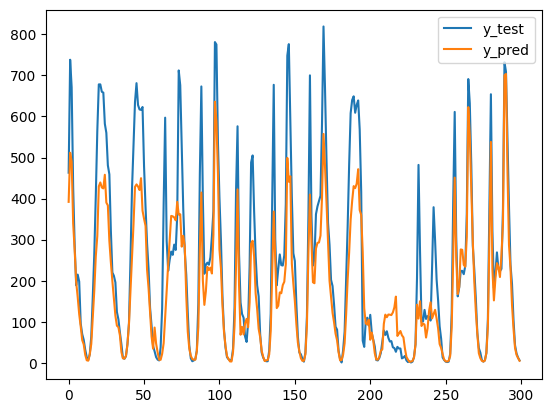

In [19]:
n = 300
plt.plot(y_test.values[:n], label="y_test")
plt.plot(y_pred[:n], label="y_pred")
plt.legend()

**Observations**

- We see that values below 200 are well predicted
- We see the peaks are significantly unpredicted

- So not as good since if we want to make a sort of dynamic pricing, we cannot predict high peaks which are useful for us to adjust prices

**Dummy Model**

A dummy model is a simple rule base model (like a minimum performance model), like the value of tomorrow will be today's value.
Then if my model cannot beat a simple rule base model that tells that the next target value is the same as the previous value, then I should do some feature engineering, change model, etc 

In [23]:
y_dummy = y_test.shift(1).fillna(method="bfill")
metrics_dummy = compute_metrics(y_test.values, y_dummy) # y_test is one before, y_dummy 
print("Metrics Baseline:", metrics_base)
print("Metrics Dummy:", metrics_dummy)

Metrics Baseline: {'MAE': 84.9, 'RSME': 116.23, 'MAPE': 34.59}
Metrics Dummy: {'MAE': 87.01, 'RSME': 128.17, 'MAPE': 55.4}


- We see that our Baseline Model does not do much better than the dummy model...
- We see that only the MAPE improves decreasing, while the other two are not, specially MAE
- This gives the conclusion that some feature engineering is definetely required

## Baseline Model with Target Lag Features

- Normally short term last values are a good predictor of how next values will be
- So, we can add lagged values of the target, and these we can assume will be available for next hour (for example last 12 target values)
- To understand how many lagged features we need, let's compute autocorrelation for the target

In [25]:
# A day 
for lag in range(1, 25):
    print(f"Lag {lag}: {df["target"].autocorr(lag=lag):.3f}")

Lag 1: 0.845
Lag 2: 0.597
Lag 3: 0.407
Lag 4: 0.274
Lag 5: 0.146
Lag 6: 0.010
Lag 7: -0.094
Lag 8: -0.114
Lag 9: -0.058
Lag 10: -0.049
Lag 11: -0.100
Lag 12: -0.131
Lag 13: -0.105
Lag 14: -0.057
Lag 15: -0.058
Lag 16: -0.094
Lag 17: -0.065
Lag 18: 0.033
Lag 19: 0.153
Lag 20: 0.262
Lag 21: 0.371
Lag 22: 0.520
Lag 23: 0.705
Lag 24: 0.809


- Assume that our ML model will learn something from last values to predict the next value

- We see that the autocorrelations are high for the first and last 3 values that indicates a strong daily seasonality

- Let's add this lags

- When the model to be run in production, from the pipeline perspective, its better to have the "cnt" column back and take the lags relative to it to avoid confusion

In [27]:
df = data.copy()
df["target"] = df["cnt"].shift(-1).fillna(method="ffill")
df.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,target
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,40.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,32.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,13.0


In [ ]:
# Add first 2 lags
for i in range(1,3):
    df[f"cnt_lag_{i}"] = df["cnt"].shift(i).fillna(method="bfill")

# Add last 2 lags 
for i in range(22,24):
    df[f"cnt_lag_{i}"] = df["cnt"].shift(i).fillna(method="bfill")

In [29]:
df.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,target,cnt_lag_1,cnt_lag_2,cnt_lag_22,cnt_lag_23
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,40.0,16.0,16.0,16.0,16.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,32.0,16.0,16.0,16.0,16.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,13.0,40.0,16.0,16.0,16.0


In [30]:
df.tail(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,target,cnt_lag_1,cnt_lag_2,cnt_lag_22,cnt_lag_23
13900,3,8,9,0,2,1,2,0.70,0.6667,0.74,0.1343,327,250.0,705.0,502.0,260.0,213.0
13901,3,8,10,0,2,1,2,0.74,0.6970,0.70,0.1343,250,214.0,327.0,705.0,285.0,260.0
13902,3,8,11,0,2,1,2,0.76,0.7273,0.66,0.0896,214,214.0,250.0,327.0,289.0,285.0


In [31]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [32]:
x_train

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,cnt_lag_1,cnt_lag_2,cnt_lag_22,cnt_lag_23
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16,16.0,16.0,16.0,16.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40,16.0,16.0,16.0,16.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32,40.0,16.0,16.0,16.0
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13,32.0,40.0,16.0,16.0
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,13.0,32.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11117,2,4,10,0,5,1,1,0.44,0.4394,0.38,0.1940,192,330.0,563.0,259.0,224.0
11118,2,4,11,0,5,1,1,0.46,0.4545,0.36,0.1343,233,192.0,330.0,203.0,259.0
11119,2,4,12,0,5,1,1,0.50,0.4848,0.31,0.0000,322,233.0,192.0,224.0,203.0
11120,2,4,13,0,5,1,1,0.52,0.5000,0.27,0.2836,358,322.0,233.0,211.0,224.0


In [33]:
%%time
model = RF(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

CPU times: user 5.33 s, sys: 83.4 ms, total: 5.41 s
Wall time: 5.72 s


In [34]:
metrics_target_lag = compute_metrics(y_test.values, y_pred)
metrics_target_lag

{'MAE': 43.44, 'RSME': 70.96, 'MAPE': 24.62}

In [35]:
print("Baseline Model:", metrics_base)
print("Baseline Model with target lag:", metrics_target_lag)

Baseline Model: {'MAE': 84.9, 'RSME': 116.23, 'MAPE': 34.59}
Baseline Model with target lag: {'MAE': 43.44, 'RSME': 70.96, 'MAPE': 24.62}


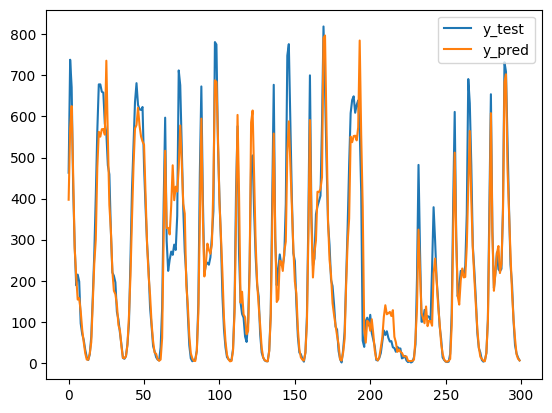

In [39]:
n = 300
plt.plot(y_test.values[:n], label="y_test")
plt.plot(y_pred[:n], label="y_pred")
plt.legend()

Now we see a significant improvement.

We clearly see that the peaks now are better captured.

## Baseline Model with All Lag Features

- Lets add the lag features for other features, not only for the target
- We will add only the first 3 lags to try on first

In [40]:
df.columns

Index(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'target',
       'cnt_lag_1', 'cnt_lag_2', 'cnt_lag_22', 'cnt_lag_23'],
      dtype='object')

In [41]:
lag_feats = ["hr", "weekday", "weathersit", "temp", "hum"]

n = 3

for feat in lag_feats:
    for i in range(1, n+1):
        df[f"{feat}_lag_{i}"] = df[feat].shift(i).fillna(method="bfill")

In [42]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [43]:
x_train.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,weekday_lag_3,weathersit_lag_1,weathersit_lag_2,weathersit_lag_3,temp_lag_1,temp_lag_2,temp_lag_3,hum_lag_1,hum_lag_2,hum_lag_3
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.22,0.24,0.24,0.80,0.81,0.81
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.22,0.22,0.24,0.80,0.80,0.81
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.24,0.22,0.22,0.75,0.80,0.80


In [44]:
x_train.columns

Index(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'cnt_lag_1',
       'cnt_lag_2', 'cnt_lag_22', 'cnt_lag_23', 'hr_lag_1', 'hr_lag_2',
       'hr_lag_3', 'weekday_lag_1', 'weekday_lag_2', 'weekday_lag_3',
       'weathersit_lag_1', 'weathersit_lag_2', 'weathersit_lag_3',
       'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'hum_lag_1', 'hum_lag_2',
       'hum_lag_3'],
      dtype='object')

In [45]:
%%time
np.random.seed(23)
model = RF(n_estimators=100, verbose=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.8s


CPU times: user 9.09 s, sys: 127 ms, total: 9.21 s
Wall time: 9.84 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [46]:
metrics_all_lags = compute_metrics(y_test.values, y_pred)
metrics_all_lags

{'MAE': 43.42, 'RSME': 71.27, 'MAPE': 24.19}

In [47]:
print("Baseline Model:", metrics_base)
print("Baseline Model with target lag:", metrics_target_lag)
print("Baseline Model with all lags:", metrics_all_lags)

Baseline Model: {'MAE': 84.9, 'RSME': 116.23, 'MAPE': 34.59}
Baseline Model with target lag: {'MAE': 43.44, 'RSME': 70.96, 'MAPE': 24.62}
Baseline Model with all lags: {'MAE': 43.42, 'RSME': 71.27, 'MAPE': 24.19}


- We see that adding the feature lags didn't improve performance significantly 

- However, with some basic feature engineering we still able to improve the scores and this we can add to the final production pipeline

## Gradient Boosting with Hyperparameters Tuning

In [48]:
df.reset_index(drop=True, inplace=True)

In [49]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [50]:
x_train

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,weekday_lag_3,weathersit_lag_1,weathersit_lag_2,weathersit_lag_3,temp_lag_1,temp_lag_2,temp_lag_3,hum_lag_1,hum_lag_2,hum_lag_3
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.22,0.24,0.24,0.80,0.81,0.81
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.22,0.22,0.24,0.80,0.80,0.81
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.24,0.22,0.22,0.75,0.80,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11117,2,4,10,0,5,1,1,0.44,0.4394,0.38,...,5.0,1.0,1.0,1.0,0.42,0.38,0.34,0.41,0.46,0.61
11118,2,4,11,0,5,1,1,0.46,0.4545,0.36,...,5.0,1.0,1.0,1.0,0.44,0.42,0.38,0.38,0.41,0.46
11119,2,4,12,0,5,1,1,0.50,0.4848,0.31,...,5.0,1.0,1.0,1.0,0.46,0.44,0.42,0.36,0.38,0.41
11120,2,4,13,0,5,1,1,0.52,0.5000,0.27,...,5.0,1.0,1.0,1.0,0.50,0.46,0.44,0.31,0.36,0.38


In [51]:
# Step 1: Define the Optuna objective with TimeSeriesSplit on x_train
def objective(trial):
    np.random.seed(42)

    # the hyperparameters to be used in each run
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.5, 5),
        "iterations": 1000,
        "loss_function": "RMSE", # a lot of values close to zero, which undermines MAPE, the model is good prediciting low values, but i want to cathc best peaks, so better to go for RMSE
        "verbose": 0
    }

    # Split the training in Training and Validation set
    train_idx = int(0.85 * x_train.shape[0])
    x_tr, x_val = x_train.iloc[:train_idx], x_train.iloc[train_idx:]
    y_tr, y_val = y_train.iloc[:train_idx], y_train.iloc[train_idx:]

    # Train model with training dataset (out val) and random params chosen in the params dict
    model = CatBoostRegressor(**params, random_seed=42)
    model.fit(x_tr, y_tr,
              eval_set=(x_val, y_val),
              early_stopping_rounds=100,
              use_best_model=True)

    # Compute predictions and RMSE
    preds = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    # Save best iteration
    trial.set_user_attr("best_iteration", model.get_best_iteration())

    return rmse

In [52]:
# Step 2: Run the Optuna study (It will train and evaluate models with params, but in an intelligent way not to be random but to in fewer iterations reach a better model/params)
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=150)

# Step 4: Train final model on full x_train with best parameters
best_params = study.best_trial.params

[I 2025-10-23 21:33:34,207] A new study created in memory with name: no-name-4faf9776-cb9a-43bb-bc14-e682d2526645
[I 2025-10-23 21:33:35,461] Trial 0 finished with value: 62.631936201851325 and parameters: {'learning_rate': 0.08116262258099886, 'depth': 8, 'l2_leaf_reg': 3.793972738151323}. Best is trial 0 with value: 62.631936201851325.
[I 2025-10-23 21:33:35,728] Trial 1 finished with value: 60.80780968109356 and parameters: {'learning_rate': 0.12374511199743694, 'depth': 3, 'l2_leaf_reg': 1.201975341512912}. Best is trial 1 with value: 60.80780968109356.
[I 2025-10-23 21:33:37,533] Trial 2 finished with value: 61.810606852953356 and parameters: {'learning_rate': 0.021035886311957897, 'depth': 8, 'l2_leaf_reg': 3.20501755284444}. Best is trial 1 with value: 60.80780968109356.
[I 2025-10-23 21:33:37,775] Trial 3 finished with value: 61.2588653634944 and parameters: {'learning_rate': 0.14453378978124864, 'depth': 3, 'l2_leaf_reg': 4.864594334728975}. Best is trial 1 with value: 60.8078

In [53]:
best_trial = study.best_trial
print("Best RMSE:", best_trial.value)
print("Best iteration (trees):", best_trial.user_attrs["best_iteration"])

Best RMSE: 56.92569050185653
Best iteration (trees): 88


In [54]:
best_params.update({
    "iterations": best_trial.user_attrs["best_iteration"],
    "loss_function": "RMSE",
    "verbose": 0
})

In [55]:
final_model = CatBoostRegressor(**best_params)
final_model.fit(x_train, y_train)

# Step 5: Predict on x_test and evaluate
y_pred = final_model.predict(x_test)
metrics_catbost = compute_metrics(y_test.values, y_pred)
metrics_catbost

{'MAE': 41.19, 'RSME': 64.82, 'MAPE': 26.62}

In [56]:
print('Baseline model scores:', metrics_base)
print('Baseline model with target lags scores:', metrics_target_lag)
print('Baseline model with all lags scores:', metrics_all_lags)
print('Tuned Catboost:', metrics_catbost)

Baseline model scores: {'MAE': 84.9, 'RSME': 116.23, 'MAPE': 34.59}
Baseline model with target lags scores: {'MAE': 43.44, 'RSME': 70.96, 'MAPE': 24.62}
Baseline model with all lags scores: {'MAE': 43.42, 'RSME': 71.27, 'MAPE': 24.19}
Tuned Catboost: {'MAE': 41.19, 'RSME': 64.82, 'MAPE': 26.62}


- We were able to reduce the RSME, which is good improvement on peak usage of bikes prediction

In [57]:
best_params

{'learning_rate': 0.14805627256213705,
 'depth': 6,
 'l2_leaf_reg': 0.6368250429014493,
 'iterations': 88,
 'loss_function': 'RMSE',
 'verbose': 0}

In [66]:
# Save the model to experiments
final_model.save_model('./models/experiments/final_catboost_model.cbm')

- We see that we are able to reduce the RMSE score (which reduces errors of peak values) and MAE score quite well.
- MAPE score has not been reduced. However, since we have quite many values close to zero, MAPE is not a good metric in this case.
- Note that in Bayesian Optimization we optimized for RMSE, we can also try to optimize for MAE.

# Conclusions

- The Baseline Random Forest model with no feature engineering gave almost the same result as the dummy model (last value shifted forward)
- Adding the target lags and feature lags improved the model significantly,
- Changing Random Forest to Catboost and tuning Catboost Hyperparameters with Bayesian Optimization helped futher improve the scores.
- For the production pipeline, we will use Catboost Model with Hyperparameter tuning.